In [2]:
# preprocessing
import os
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder

from collections import Counter
from imblearn.over_sampling import SMOTE
from numpy import where
from imblearn.over_sampling import ADASYN

import warnings
warnings.filterwarnings( action= 'ignore')

sns.set_theme()


# metric 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, f1_score, recall_score

from imblearn.pipeline import make_pipeline

# tuning parameter
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,cross_val_score

# train model
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection

import function as fn

# Exploratory data analysis (EDA)

In [3]:
# read csv cleaned data
df_labeled = pd.read_csv('/Users/nontanatto/Desktop/DS/Assignment1/new_DS_ver2_includeIBI/merged_data_labeled.csv')
df_labeled

,X,Y,Z,EDA,HR,TEMP,IBI,id,datetime,label
0,-72.0,68.0,-38.0,22.903978,90.85,35.73,0.406250,94,2020-05-10 23:55:00.000000000,2.0
1,-18.0,74.0,-21.0,22.903978,90.85,35.73,0.406250,94,2020-05-10 23:55:00.031249920,2.0
2,-17.0,69.0,-36.0,22.903978,90.85,35.73,0.406250,94,2020-05-10 23:55:00.062500096,2.0
3,-27.0,57.0,-20.0,22.903978,90.85,35.73,0.406250,94,2020-05-10 23:55:00.093750016,2.0
4,7.0,61.0,1.0,22.903978,90.85,35.73,0.406250,94,2020-05-10 23:55:00.124999936,2.0
...,...,...,...,...,...,...,...,...,...,...
11543751,-59.0,14.0,1.0,5.279665,75.48,30.83,0.796875,7A,2020-07-07 13:42:56.171875072,2.0
11543752,-59.0,14.0,1.0,5.279665,75.48,30.83,0.781250,7A,2020-07-07 13:43:37.265625088,2.0
11543753,-59.0,14.0,1.0,5.279665,75.48,30.83,0.796875,7A,2020-07-07 13:43:38.828124928,2.0
11543754,-59.0,14.0,1.0,5.279665,75.48,30.83,0.765625,7A,2020-07-07 13:43:40.390625024,2.0


In [27]:
# Sort ascending data point by datetime
df_labeled = df_labeled.sort_values(by='datetime').reset_index(drop=True)

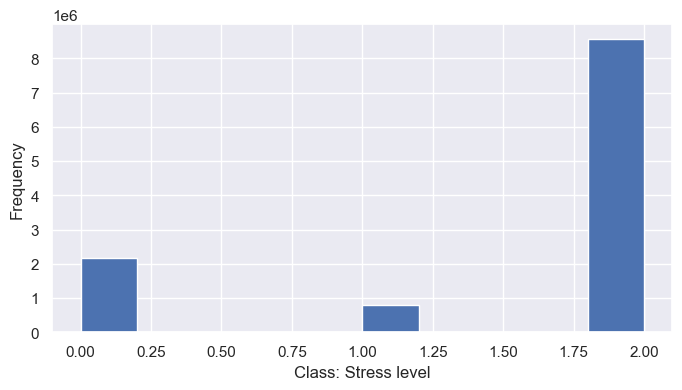

In [4]:
df_labeled["label"].hist(figsize=(8,4))   
plt.xlabel("Class: Stress level")
plt.ylabel("Frequency")

plt.show()

From figure above show that the distribution of class which is stress level = 0 (not stress), stress level = 1 (normal) and class level 2 (stress)

The graph shows that the class is imbalanced, which means that the quantity of stress data outweighs the quantity of normal data and not stress data.

As a result, the F1 score is appropriate for evaluating this dataset.

### Calculate Accerleration from Acc X Y Z

**Acceleration**

Due to Acceleration of movement may affect to stress level, then I'll add ACC feature into Table

In [29]:
# calculate accelarator from X, Y, Z
def acc_cal(x, y, z):
    return np.sqrt(x**2 + y**2 +z**2)

# map the accerleration calculation in to the dataframe
df_labeled['ACC'] = df_labeled.apply(lambda row: acc_cal(row['X'], row['Y'], row['Z']), axis=1)
df_labeled.head()

,X,Y,Z,EDA,HR,TEMP,IBI,id,datetime,label,ACC
0,-22.0,-43.0,127.0,21.941885,82.67,36.49,0.765625,5C,2020-04-14 22:31:00.000000000,1.0,135.874943
1,-22.0,-43.0,127.0,21.941885,82.67,36.49,0.765625,5C,2020-04-14 22:31:00.031249920,1.0,135.874943
2,-22.0,-43.0,127.0,21.941885,82.67,36.49,0.765625,5C,2020-04-14 22:31:00.062500096,1.0,135.874943
3,-22.0,-43.0,127.0,21.941885,82.67,36.49,0.765625,5C,2020-04-14 22:31:00.093750016,1.0,135.874943
4,-22.0,-43.0,127.0,21.941885,82.67,36.49,0.765625,5C,2020-04-14 22:31:00.124999936,1.0,135.874943


**Distributed of all data**

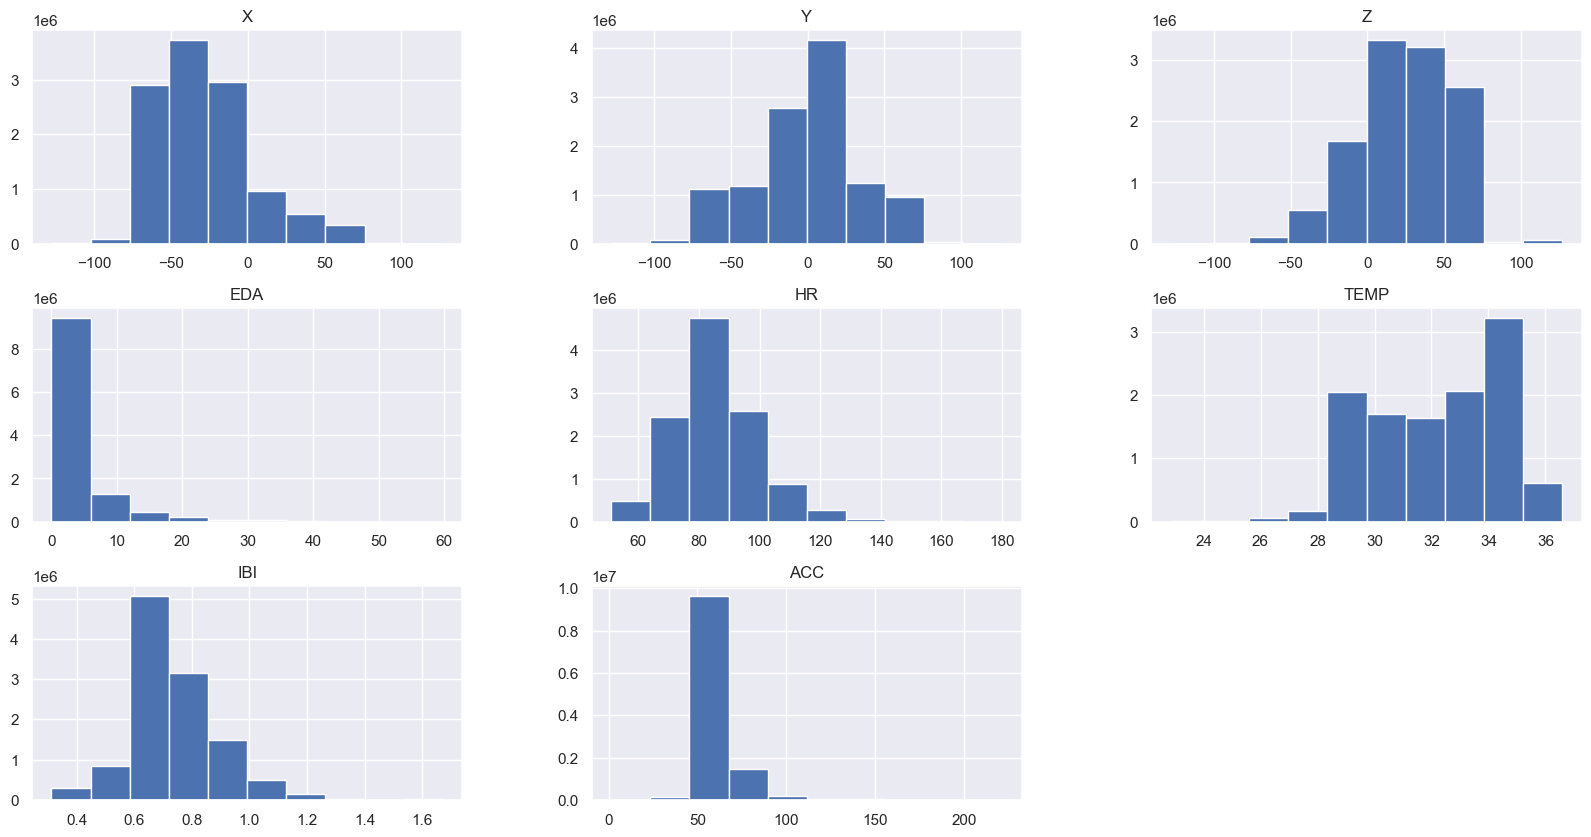

In [30]:
# Create a histogram of the data
df_labeled.drop(['datetime','label','id'],axis=1).hist(figsize=(20,10))

# Show the plot
plt.show()

Each graph display the distribution of the data

From visualization above, 

**Added data**

    ACC : represent Acceleration of movement calculated from X, Y and C
    
**Signal data**
    
    X, Y, Z: represent the x, y, z-Axis acceleration
    EDA: represent Electrodermal activity of the skin signal
    HR: represent heart rate signal
    TEMP: represent skin temperature in Celcius
    IBI: represent Inter-beat interval or beat-to-beat interva
    
    (note: you can see statistical detail for each column below)


## Analysis raw data with time series

To analyze the differentiation of raw signal pattern under different stress levels, time series data was plotted for person ID "5C".

In [31]:
df_5C = df_labeled[df_labeled['id'] == '5C'].reset_index(drop= True)

### Plot X Y Z Accerelometer

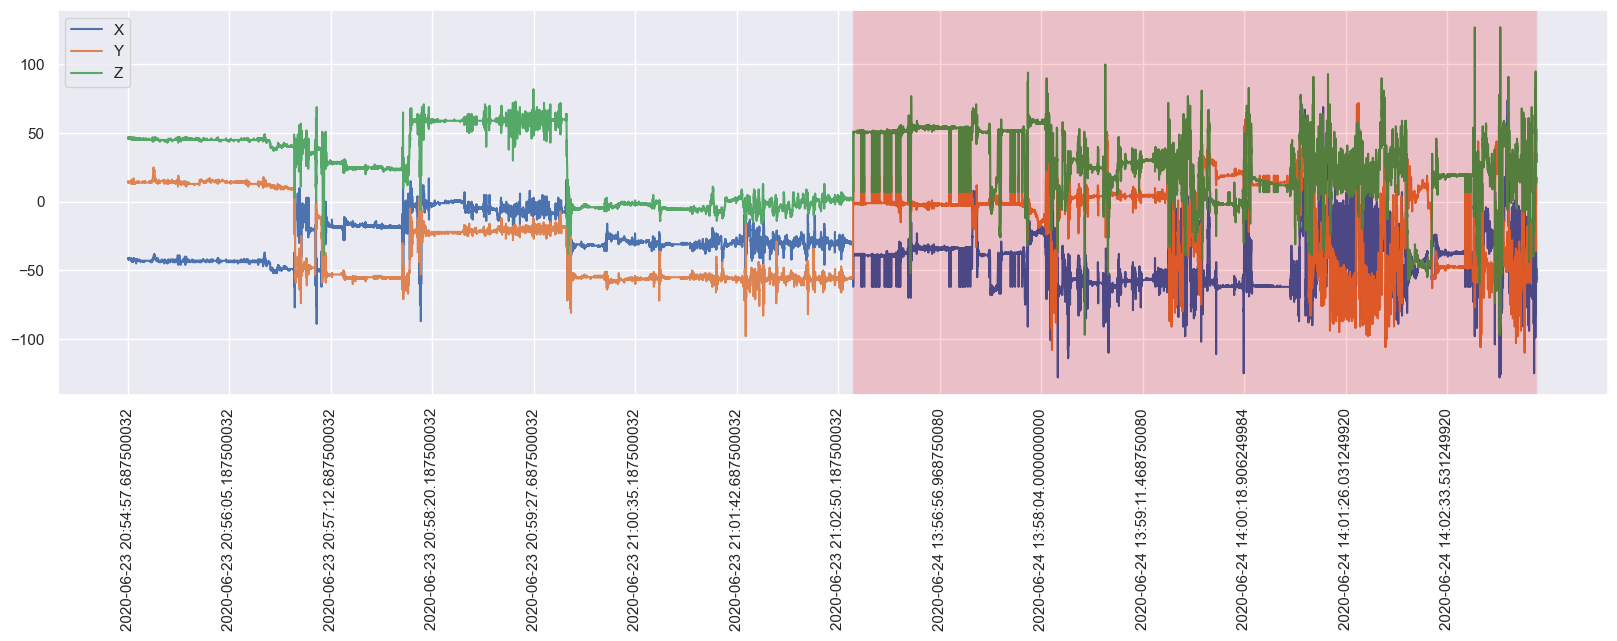

In [32]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(df_5C['datetime'][420000:450000], df_5C['X'][420000:450000], label='X')
ax.plot(df_5C['datetime'][420000:450000], df_5C['Y'][420000:450000], label='Y')
ax.plot(df_5C['datetime'][420000:450000], df_5C['Z'][420000:450000], label='Z')

# Set the x-tick labels for every nth tick
n = 36*60
xticks = ax.get_xticks()[::n]
xtick_labels = df_5C['datetime'][420000:450000][::n]
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=90)


for i,e in enumerate(df_5C['label'][420000:450000]):
    if e == 1:
        ax.axvline(x=i, color='yellow', alpha = 0.005)
    if e == 2:
        ax.axvline(x=i, color='red', alpha = 0.005)
                   
ax.legend()

plt.show()

### Plot Accerelation and Heart rate

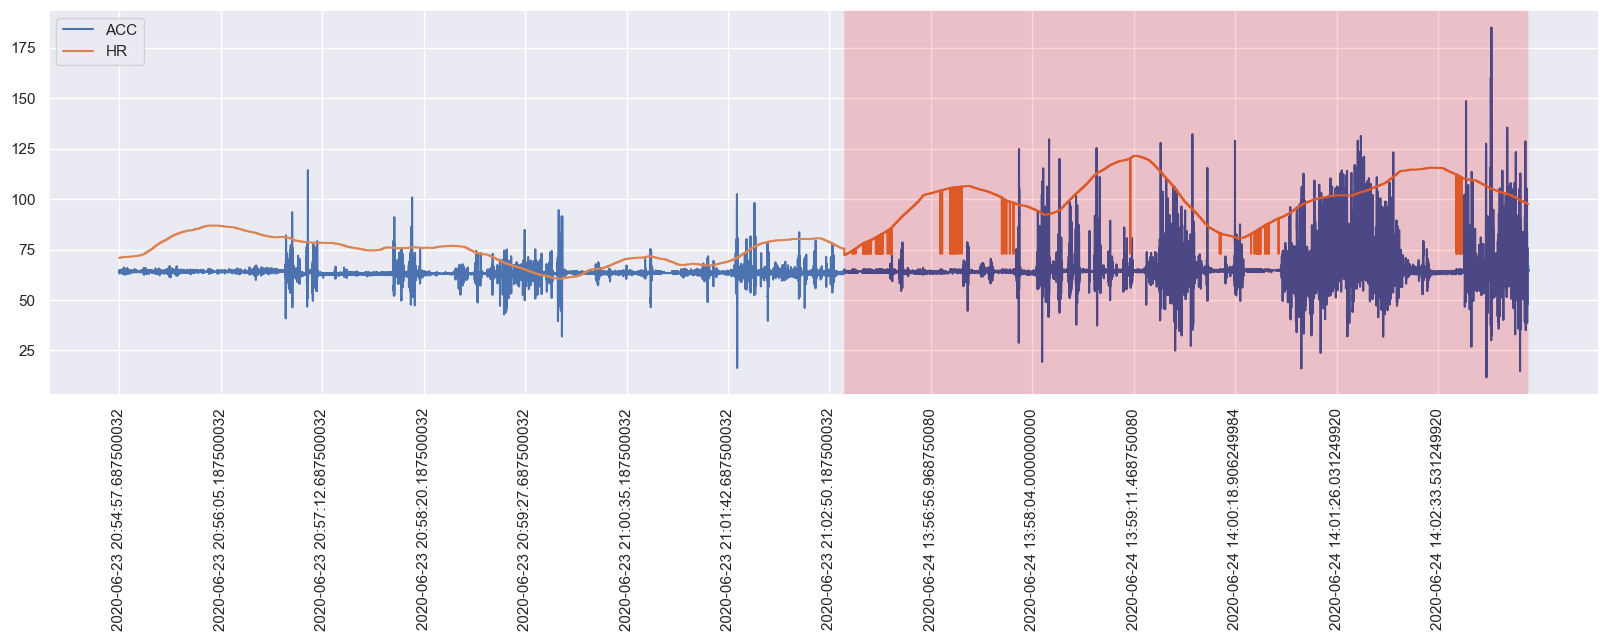

In [33]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(df_5C['datetime'][420000:450000], df_5C['ACC'][420000:450000], label='ACC')
ax.plot(df_5C['datetime'][420000:450000], df_5C['HR'][420000:450000], label='HR')
#ax.plot(df_5C['datetime'][420000:450000], df_5C['TEMP'][420000:450000], label='TEMP')


# Set the x-tick labels for every nth tick
n = 36*60
xticks = ax.get_xticks()[::n]
xtick_labels = df_5C['datetime'][420000:450000][::n]
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=90)


for i,e in enumerate(df_5C['label'][420000:450000]):
    if e == 1:
        ax.axvline(x=i, color='yellow', alpha = 0.005)
    if e == 2:
        ax.axvline(x=i, color='red', alpha = 0.005)
                   
ax.legend()

plt.show()

### Plot EDA and IBI

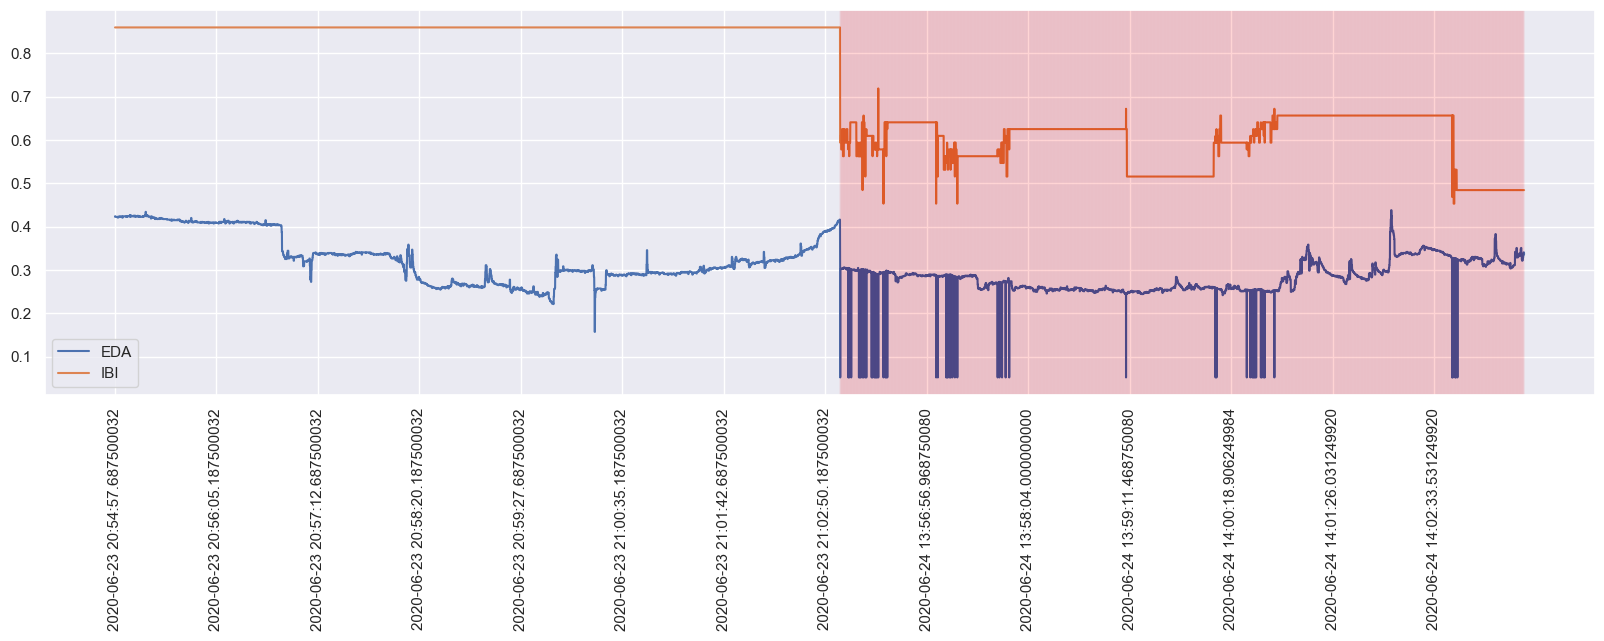

In [34]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(df_5C['datetime'][420000:450000], df_5C['EDA'][420000:450000], label='EDA')
ax.plot(df_5C['datetime'][420000:450000], df_5C['IBI'][420000:450000], label='IBI')


# Set the x-tick labels for every nth tick
n = 36*60
xticks = ax.get_xticks()[::n]
xtick_labels = df_5C['datetime'][420000:450000][::n]
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=90)


for i,e in enumerate(df_5C['label'][420000:450000]):
    if e == 1:
        ax.axvline(x=i, color='yellow', alpha = 0.005)
    if e == 2:
        ax.axvline(x=i, color='red', alpha = 0.005)
                   
ax.legend()

plt.show()

It can be observed from the plotted raw signals that there is an increase in the fluctuation of the accelerometer, acceleration Heart rate when the stress level changes from 0 to 2, also change pattern of signal IBI and EDA.

**Then I would like to findout how distribution of each signal in each stress level look likes.**

In [35]:
df_stress0 = df_labeled[df_labeled['label'] == 0]
df_stress1 = df_labeled[df_labeled['label'] == 1]
df_stress2 = df_labeled[df_labeled['label'] == 2]

In [36]:
# to show statisticvalue of distribution
def stat(x: str)->None:

    print(f"Stress LV0 {x} | mean: {np.mean(df_stress0[x]):.4f}, Std: {np.std(df_stress0[x]):.4f}, Med: {np.median(df_stress0[x]):.4f}, Min: {np.min(df_stress0[x]):.4f}, Max: {np.max(df_stress0[x]):.4f}, Skewness: {df_stress0[x].skew():.4f}, Kurtosis: {df_stress0[x].kurtosis():.4f} ")
    print(f"Stress LV1 {x} | mean: {np.mean(df_stress1[x]):.4f}, Std: {np.std(df_stress1[x]):.4f}, Med: {np.median(df_stress1[x]):.4f}, Min: {np.min(df_stress1[x]):.4f}, Max: {np.max(df_stress1[x]):.4f}, Skewness: {df_stress1[x].skew():.4f}, Kurtosis: {df_stress1[x].kurtosis():.4f}")
    print(f"Stress LV2 {x} | mean: {np.mean(df_stress2[x]):.4f}, Std: {np.std(df_stress2[x]):.4f}, Med: {np.median(df_stress2[x]):.4f}, Min: {np.min(df_stress2[x]):.4f}, Max: {np.max(df_stress2[x]):.4f}, Skewness: {df_stress2[x].skew():.4f}, Kurtosis: {df_stress2[x].kurtosis():.4f}\n")

### Distribution plot for EDA

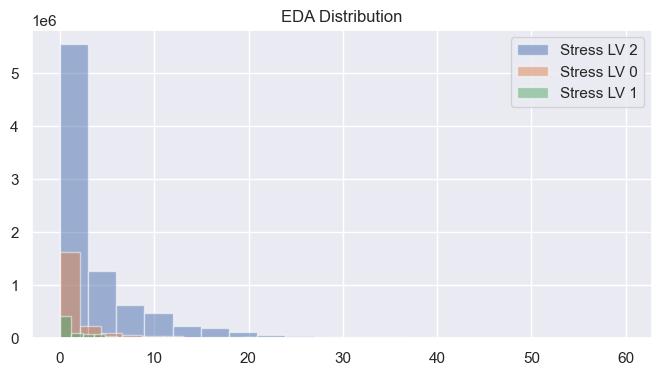

Stress LV0 EDA | mean: 2.9472, Std: 6.4708, Med: 0.4641, Min: 0.0000, Max: 43.5634, Skewness: 3.6099, Kurtosis: 13.6858 
Stress LV1 EDA | mean: 3.0656, Std: 4.6852, Med: 1.0870, Min: 0.0000, Max: 24.1673, Skewness: 2.3191, Kurtosis: 5.1540
Stress LV2 EDA | mean: 3.6768, Std: 5.4976, Med: 1.5487, Min: 0.0000, Max: 59.7607, Skewness: 2.8300, Kurtosis: 11.5828



In [37]:
plt.figure(figsize=(8, 4))
plt.hist(df_stress2['EDA'], bins=20, alpha=0.5, label='Stress LV 2')
plt.hist(df_stress0['EDA'], bins=20, alpha=0.5, label='Stress LV 0')
plt.hist(df_stress1['EDA'], bins=20, alpha=0.5, label='Stress LV 1')

plt.legend(loc='upper right')
plt.title('EDA Distribution')
plt.show()

stat('EDA')

From the statistical values of EDA for each stress level:

Overall, the EDA values are higher for Stress LV1 and Stress LV2 compared to Stress LV0. Additionally, the distributions of EDA values are skewed towards higher values for all three stress levels, with Stress LV0 having the highest degree of skewness

### Distribution plot for TEMP

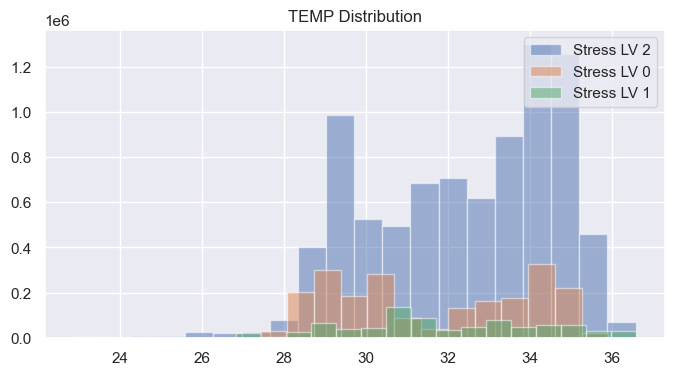

Stress LV0 TEMP | mean: 31.6270, Std: 2.3430, Med: 31.0900, Min: 22.8500, Max: 35.9100, Skewness: -0.0162, Kurtosis: -1.3275 
Stress LV1 TEMP | mean: 31.9899, Std: 2.3334, Med: 31.5900, Min: 24.3900, Max: 36.5900, Skewness: 0.0313, Kurtosis: -0.7414
Stress LV2 TEMP | mean: 32.3998, Std: 2.2275, Med: 32.8100, Min: 22.8500, Max: 36.5700, Skewness: -0.4384, Kurtosis: -0.7349



In [38]:
plt.figure(figsize=(8, 4))
plt.hist(df_stress2['TEMP'], bins=20, alpha=0.5, label='Stress LV 2')
plt.hist(df_stress0['TEMP'], bins=20, alpha=0.5, label='Stress LV 0')
plt.hist(df_stress1['TEMP'], bins=20, alpha=0.5, label='Stress LV 1')

plt.legend(loc='upper right')
plt.title('TEMP Distribution')
plt.show()

stat('TEMP')

The mean temperature values are increasing from Stress LV0 to Stress LV2. The standard deviation for all three stress levels is relatively similar. The median temperature values also show an increasing trend from Stress LV0 to Stress LV2. The minimum temperature values for all three stress levels are relatively similar. However, the maximum temperature values are higher for Stress LV1 and Stress LV2 compared to Stress LV0. The skewness value for Stress LV0 indicates a near-normal distribution, while Stress LV1 and Stress LV2 have slightly negative and negative skewness values, respectively, indicating a slightly left-skewed distribution.

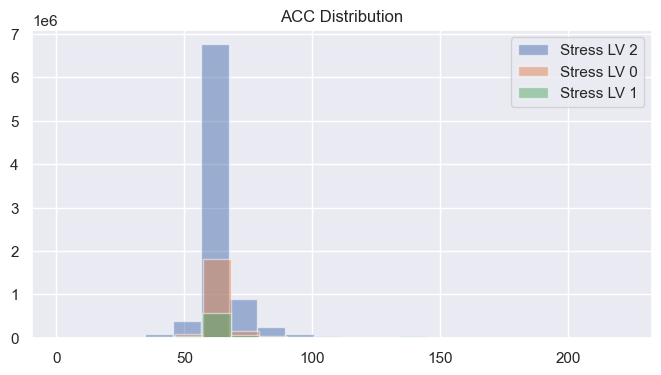

Stress LV0 ACC | mean: 64.6961, Std: 7.6462, Med: 63.9140, Min: 2.4495, Max: 221.7025, Skewness: 3.4888, Kurtosis: 37.8573 
Stress LV1 ACC | mean: 69.7363, Std: 20.3469, Med: 64.1015, Min: 2.2361, Max: 221.7025, Skewness: 2.5508, Kurtosis: 6.3283
Stress LV2 ACC | mean: 65.0178, Std: 8.7677, Med: 64.0391, Min: 1.4142, Max: 221.7025, Skewness: 3.1853, Kurtosis: 28.1573



In [39]:
plt.figure(figsize=(8, 4))
plt.hist(df_stress2['ACC'], bins=20, alpha=0.5, label='Stress LV 2')
plt.hist(df_stress0['ACC'], bins=20, alpha=0.5, label='Stress LV 0')
plt.hist(df_stress1['ACC'], bins=20, alpha=0.5, label='Stress LV 1')

plt.legend(loc='upper right')
plt.title('ACC Distribution')
plt.show()

stat('ACC')

The mean values of ACC for Stress LV1 is higher than those of Stress LV0 and Stress LV2. The standard deviation values are highest for Stress LV1, indicating a greater degree of variability in the ACC values for this stress level. The distributions of ACC values for all stress levels are skewed towards higher values, with Stress LV0 and Stress LV2 having similar degrees of skewness and Stress LV1 having a slightly lower degree of skewness. It is worth noting that the maximum value of ACC for all stress levels is the same (221.7025), while the minimum values vary.

### Distribution plot for HR

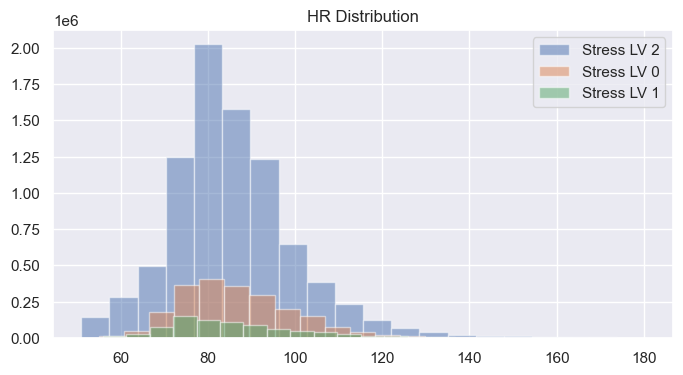

Stress LV0 HR | mean: 86.6476, Std: 13.0195, Med: 84.8800, Min: 55.1300, Max: 169.9300, Skewness: 0.7786, Kurtosis: 1.1706 
Stress LV1 HR | mean: 86.4017, Std: 15.4198, Med: 83.3800, Min: 55.9200, Max: 163.5000, Skewness: 1.0264, Kurtosis: 1.5200
Stress LV2 HR | mean: 85.4665, Std: 14.3729, Med: 83.6300, Min: 51.0000, Max: 180.2300, Skewness: 0.9504, Kurtosis: 2.5968



In [40]:
plt.figure(figsize=(8, 4))
plt.hist(df_stress2['HR'], bins=20, alpha=0.5, label='Stress LV 2')
plt.hist(df_stress0['HR'], bins=20, alpha=0.5, label='Stress LV 0')
plt.hist(df_stress1['HR'], bins=20, alpha=0.5, label='Stress LV 1')

plt.legend(loc='upper right')
plt.title('HR Distribution')
plt.show()

stat('HR')

The mean HR values for all three stress levels are relatively similar, ranging from 85.4665 to 86.6476 beats per minute. However, the standard deviation values are higher for Stress LV1 and Stress LV2 compared to Stress LV0, indicating greater variability in HR values for these stress levels. The distributions of HR values for all three stress levels are positively skewed, with Stress LV1 having the highest degree of skewness. The minimum and maximum HR values for each stress level are also within a similar range, with the exception of Stress LV2 having a maximum HR value of 180.23 beats per minute, which is higher than the other two stress levels.

### Distribution plot for IBI

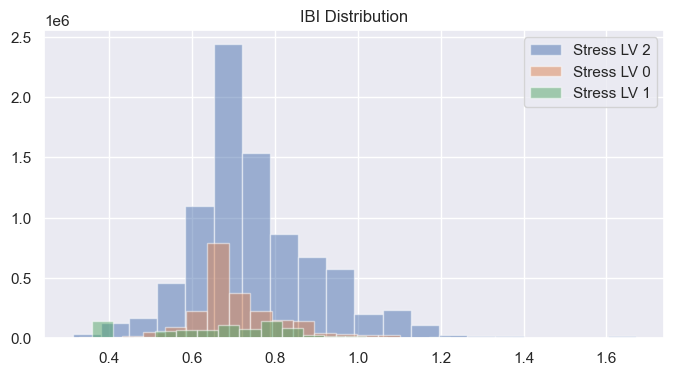

Stress LV0 IBI | mean: 0.7097, Std: 0.1061, Med: 0.6719, Min: 0.3281, Max: 1.3594, Skewness: 0.7248, Kurtosis: 1.8119 
Stress LV1 IBI | mean: 0.6730, Std: 0.1840, Med: 0.7031, Min: 0.3594, Max: 1.3750, Skewness: -0.1737, Kurtosis: -0.2233
Stress LV2 IBI | mean: 0.7519, Std: 0.1557, Med: 0.7188, Min: 0.3125, Max: 1.6719, Skewness: 1.0267, Kurtosis: 2.9900



In [41]:
plt.figure(figsize=(8, 4))
plt.hist(df_stress2['IBI'], bins=20, alpha=0.5, label='Stress LV 2')
plt.hist(df_stress0['IBI'], bins=20, alpha=0.5, label='Stress LV 0')
plt.hist(df_stress1['IBI'], bins=20, alpha=0.5, label='Stress LV 1')

plt.legend(loc='upper right')

plt.title('IBI Distribution')
plt.show()

stat('IBI')

The IBI (Interbeat Interval) values for Stress LV0 and Stress LV2 are higher than that of Stress LV1. Stress LV0 has the highest mean and median IBI values, while Stress LV1 has the lowest. The standard deviation of IBI values is highest for Stress LV1. The distributions of IBI values are positively skewed for Stress LV0 and Stress LV2, while it is negatively skewed for Stress LV1. All three stress levels have similar minimum and maximum IBI values.

### Distribution plot for X Y Z ACC

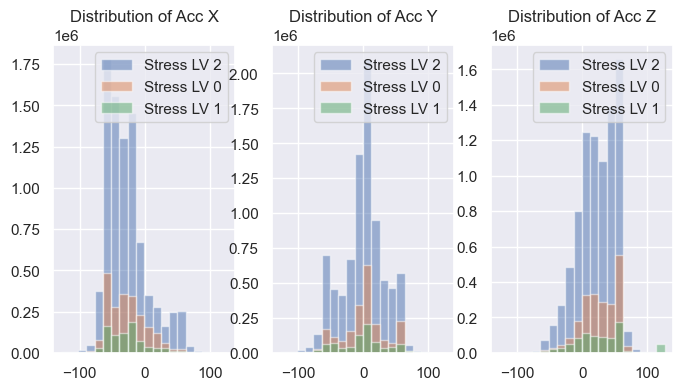

Stress LV0 X | mean: -27.6363, Std: 29.5203, Med: -30.0000, Min: -128.0000, Max: 127.0000, Skewness: 0.6416, Kurtosis: 0.1988 
Stress LV1 X | mean: -28.4784, Std: 28.6481, Med: -28.0000, Min: -128.0000, Max: 127.0000, Skewness: 0.7134, Kurtosis: 0.7350
Stress LV2 X | mean: -28.3672, Std: 32.1078, Med: -34.0000, Min: -128.0000, Max: 127.0000, Skewness: 1.0442, Kurtosis: 0.9519

Stress LV0 Y | mean: 0.7938, Std: 33.3228, Med: 2.0000, Min: -128.0000, Max: 127.0000, Skewness: -0.1409, Kurtosis: -0.0726 
Stress LV1 Y | mean: -1.4926, Std: 35.9508, Med: 2.0000, Min: -128.0000, Max: 127.0000, Skewness: -0.1229, Kurtosis: -0.2283
Stress LV2 Y | mean: -1.2383, Std: 33.2085, Med: 1.0000, Min: -128.0000, Max: 127.0000, Skewness: -0.2335, Kurtosis: -0.0596

Stress LV0 Z | mean: 26.8406, Std: 27.8817, Med: 28.0000, Min: -128.0000, Max: 127.0000, Skewness: -0.5438, Kurtosis: -0.0469 
Stress LV1 Z | mean: 27.2732, Std: 40.0862, Med: 25.0000, Min: -128.0000, Max: 127.0000, Skewness: 0.4901, Kurtosis: 

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))

ax[0].hist(df_stress2['X'], bins=20, alpha=0.5, label='Stress LV 2')
ax[0].hist(df_stress0['X'], bins=20, alpha=0.5, label='Stress LV 0')
ax[0].hist(df_stress1['X'], bins=20, alpha=0.5, label='Stress LV 1')

ax[1].hist(df_stress2['Y'], bins=20, alpha=0.5, label='Stress LV 2')
ax[1].hist(df_stress0['Y'], bins=20, alpha=0.5, label='Stress LV 0')
ax[1].hist(df_stress1['Y'], bins=20, alpha=0.5, label='Stress LV 1')

ax[2].hist(df_stress2['Z'], bins=20, alpha=0.5, label='Stress LV 2')
ax[2].hist(df_stress0['Z'], bins=20, alpha=0.5, label='Stress LV 0')
ax[2].hist(df_stress1['Z'], bins=20, alpha=0.5, label='Stress LV 1')

ax[0].set_title('Distribution of Acc X')
ax[1].set_title('Distribution of Acc Y')
ax[2].set_title('Distribution of Acc Z')

for i in range(3):
    ax[i].legend(loc='upper right')

plt.show()

stat('X')
stat('Y')
stat('Z')

### Correlation between X and X, X and Y

<AxesSubplot: >

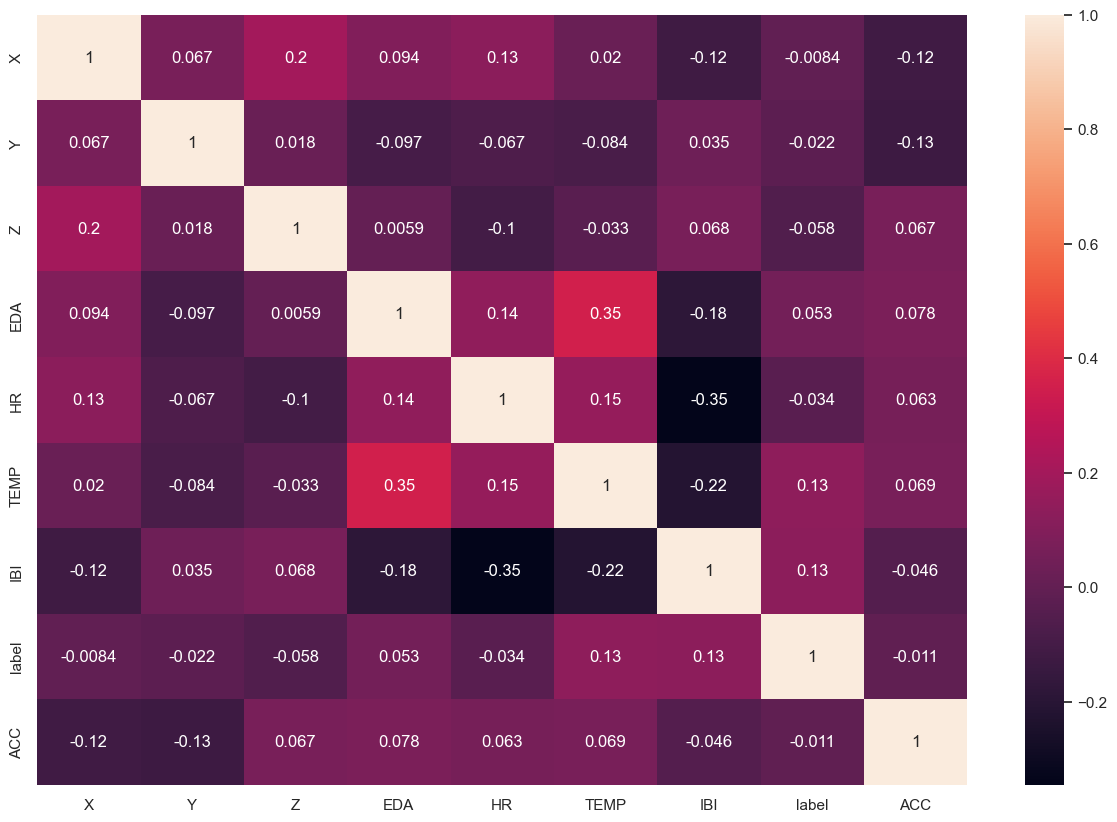

In [43]:
temp = df_labeled.drop(['datetime','id'], axis=1)
fig = plt.figure(figsize=(15,10))
sns.heatmap(temp.corr(),annot=True)

In [2]:
SAVE_PATH = '/Users/nontanatto/Desktop/DS'

In [44]:
df_labeled.to_csv(os.path.join(SAVE_PATH, "data.csv"), index=False)

The figure show correlation between feature to feature and feature to label

It can be seen that, temp, IBI and HR are the most correlation, 0.13, 0.13 and 0.15 respectively to label, while hour and month are the features which correlation to each other too much (-0.6), One of them may remove in the future, for instance.
***

# Feature Engineering

In [3]:
df_data = pd.read_csv(SAVE_PATH + '/data.csv')

In [4]:
# read excel
sv_df = pd.read_excel('/Users/nontanatto/desktop/DS/Assignment1/SurveyResults.xlsx')
time_obj = min(sv_df['duration'])

time_str = time_obj.strftime("%H:%M:%S")
print(f'Shortest duration is {time_str}')

Shortest duration is 00:02:00


From above it can be seen that the shortest duration stress Level label is 2 minutes, Window size should be select below 2 minute. then I choose 1 minute to be window size with 50% overlapping

- Mean - to get a general idea of the central tendency of the signal within the 2-minute window.
- Standard deviation - to measure the degree of dispersion or variability of the signal within the 2-minute window.
- Minimum and Maximum - to get an idea of the range of values of the signal within the 2-minute window.
- Skewness - to detect whether the distribution of the signal values within the 2-minute window is symmetric or skewed towards one direction.
- Kurtosis - to measure the degree of peakedness or flatness of the distribution of the signal values within the 2-minute window.

leave user id 94 as testset

To prevent data leakage and ensure that the model is trained and tested on independent sets of data, it is common to use a fixed-length window size and avoid overlap between windows. This approach ensures that each window is completely contained within either the training set or the testing set, and eliminates the possibility of data from the training set leaking into the testing set.

By using a small window size, it is possible to capture temporal dynamics within the data without requiring overlap between windows. This can help to prevent data leakage while still allowing the model to learn from the temporal structure of the data.

In [5]:
# Calculate StatFeature Non overlap
df_featured = fn.feature_extraction(df_data)

In [6]:
df_featured

,X_mean,Y_mean,Z_mean,EDA_mean,HR_mean,ACC_mean,TEMP_mean,IBI_mean,X_std,Y_std,...,IBI_kur,X_med,Y_med,Z_med,EDA_med,HR_med,ACC_med,TEMP_med,IBI_med,label
0,-21.872917,1.763281,60.127344,3.283078,71.268422,64.761057,34.354203,0.890584,7.103851,5.012197,...,3840.000000,-23.0,2.0,60.0,3.183347,71.520,64.629715,34.34,0.890625,0.0
1,-22.801562,2.186198,59.285677,2.951972,75.660922,64.920153,34.490086,0.890625,9.079040,5.948986,...,0.000000,-22.0,1.0,60.0,2.942057,72.345,64.629715,34.50,0.890625,0.0
2,-24.177083,1.693750,58.906771,2.895304,84.421844,64.990924,34.658427,0.890625,8.996564,5.594714,...,0.000000,-24.0,1.0,60.0,2.875480,86.490,64.652920,34.65,0.890625,0.0
3,-22.711979,1.320573,60.141927,2.676548,82.114096,64.901541,34.734844,0.892757,7.828779,4.320043,...,38.463936,-23.0,2.0,60.0,2.646301,79.970,64.652920,34.75,0.890625,0.0
4,-30.685938,4.209896,46.335677,2.360239,76.994401,64.860024,34.761969,0.909033,20.126089,7.288367,...,-0.991248,-24.0,2.0,60.0,2.356655,77.110,64.652920,34.75,0.890625,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6002,-28.379427,-40.894271,18.396875,4.908347,106.377982,65.569308,34.046042,0.645984,19.978604,29.811132,...,2.285587,-19.0,-58.0,16.0,4.717536,105.870,63.340350,34.11,0.671875,2.0
6003,-18.871875,-56.574219,15.752344,4.326050,100.002805,63.482584,33.844911,0.642509,8.928196,11.421212,...,1.616430,-18.0,-58.0,16.0,4.433440,101.550,63.095166,33.77,0.656250,2.0
6004,-26.526302,-29.906250,22.776042,4.001526,94.167021,64.412294,33.775833,0.668400,22.503158,36.467516,...,11.340288,-20.0,-50.0,18.0,3.956756,93.850,63.356136,33.75,0.671875,2.0
6005,-40.336458,-4.189844,17.645312,3.905104,85.793000,64.940108,33.876792,0.671875,27.075619,30.692259,...,0.000000,-48.0,-4.0,20.0,3.839475,88.330,64.152163,33.89,0.671875,2.0


<AxesSubplot: >

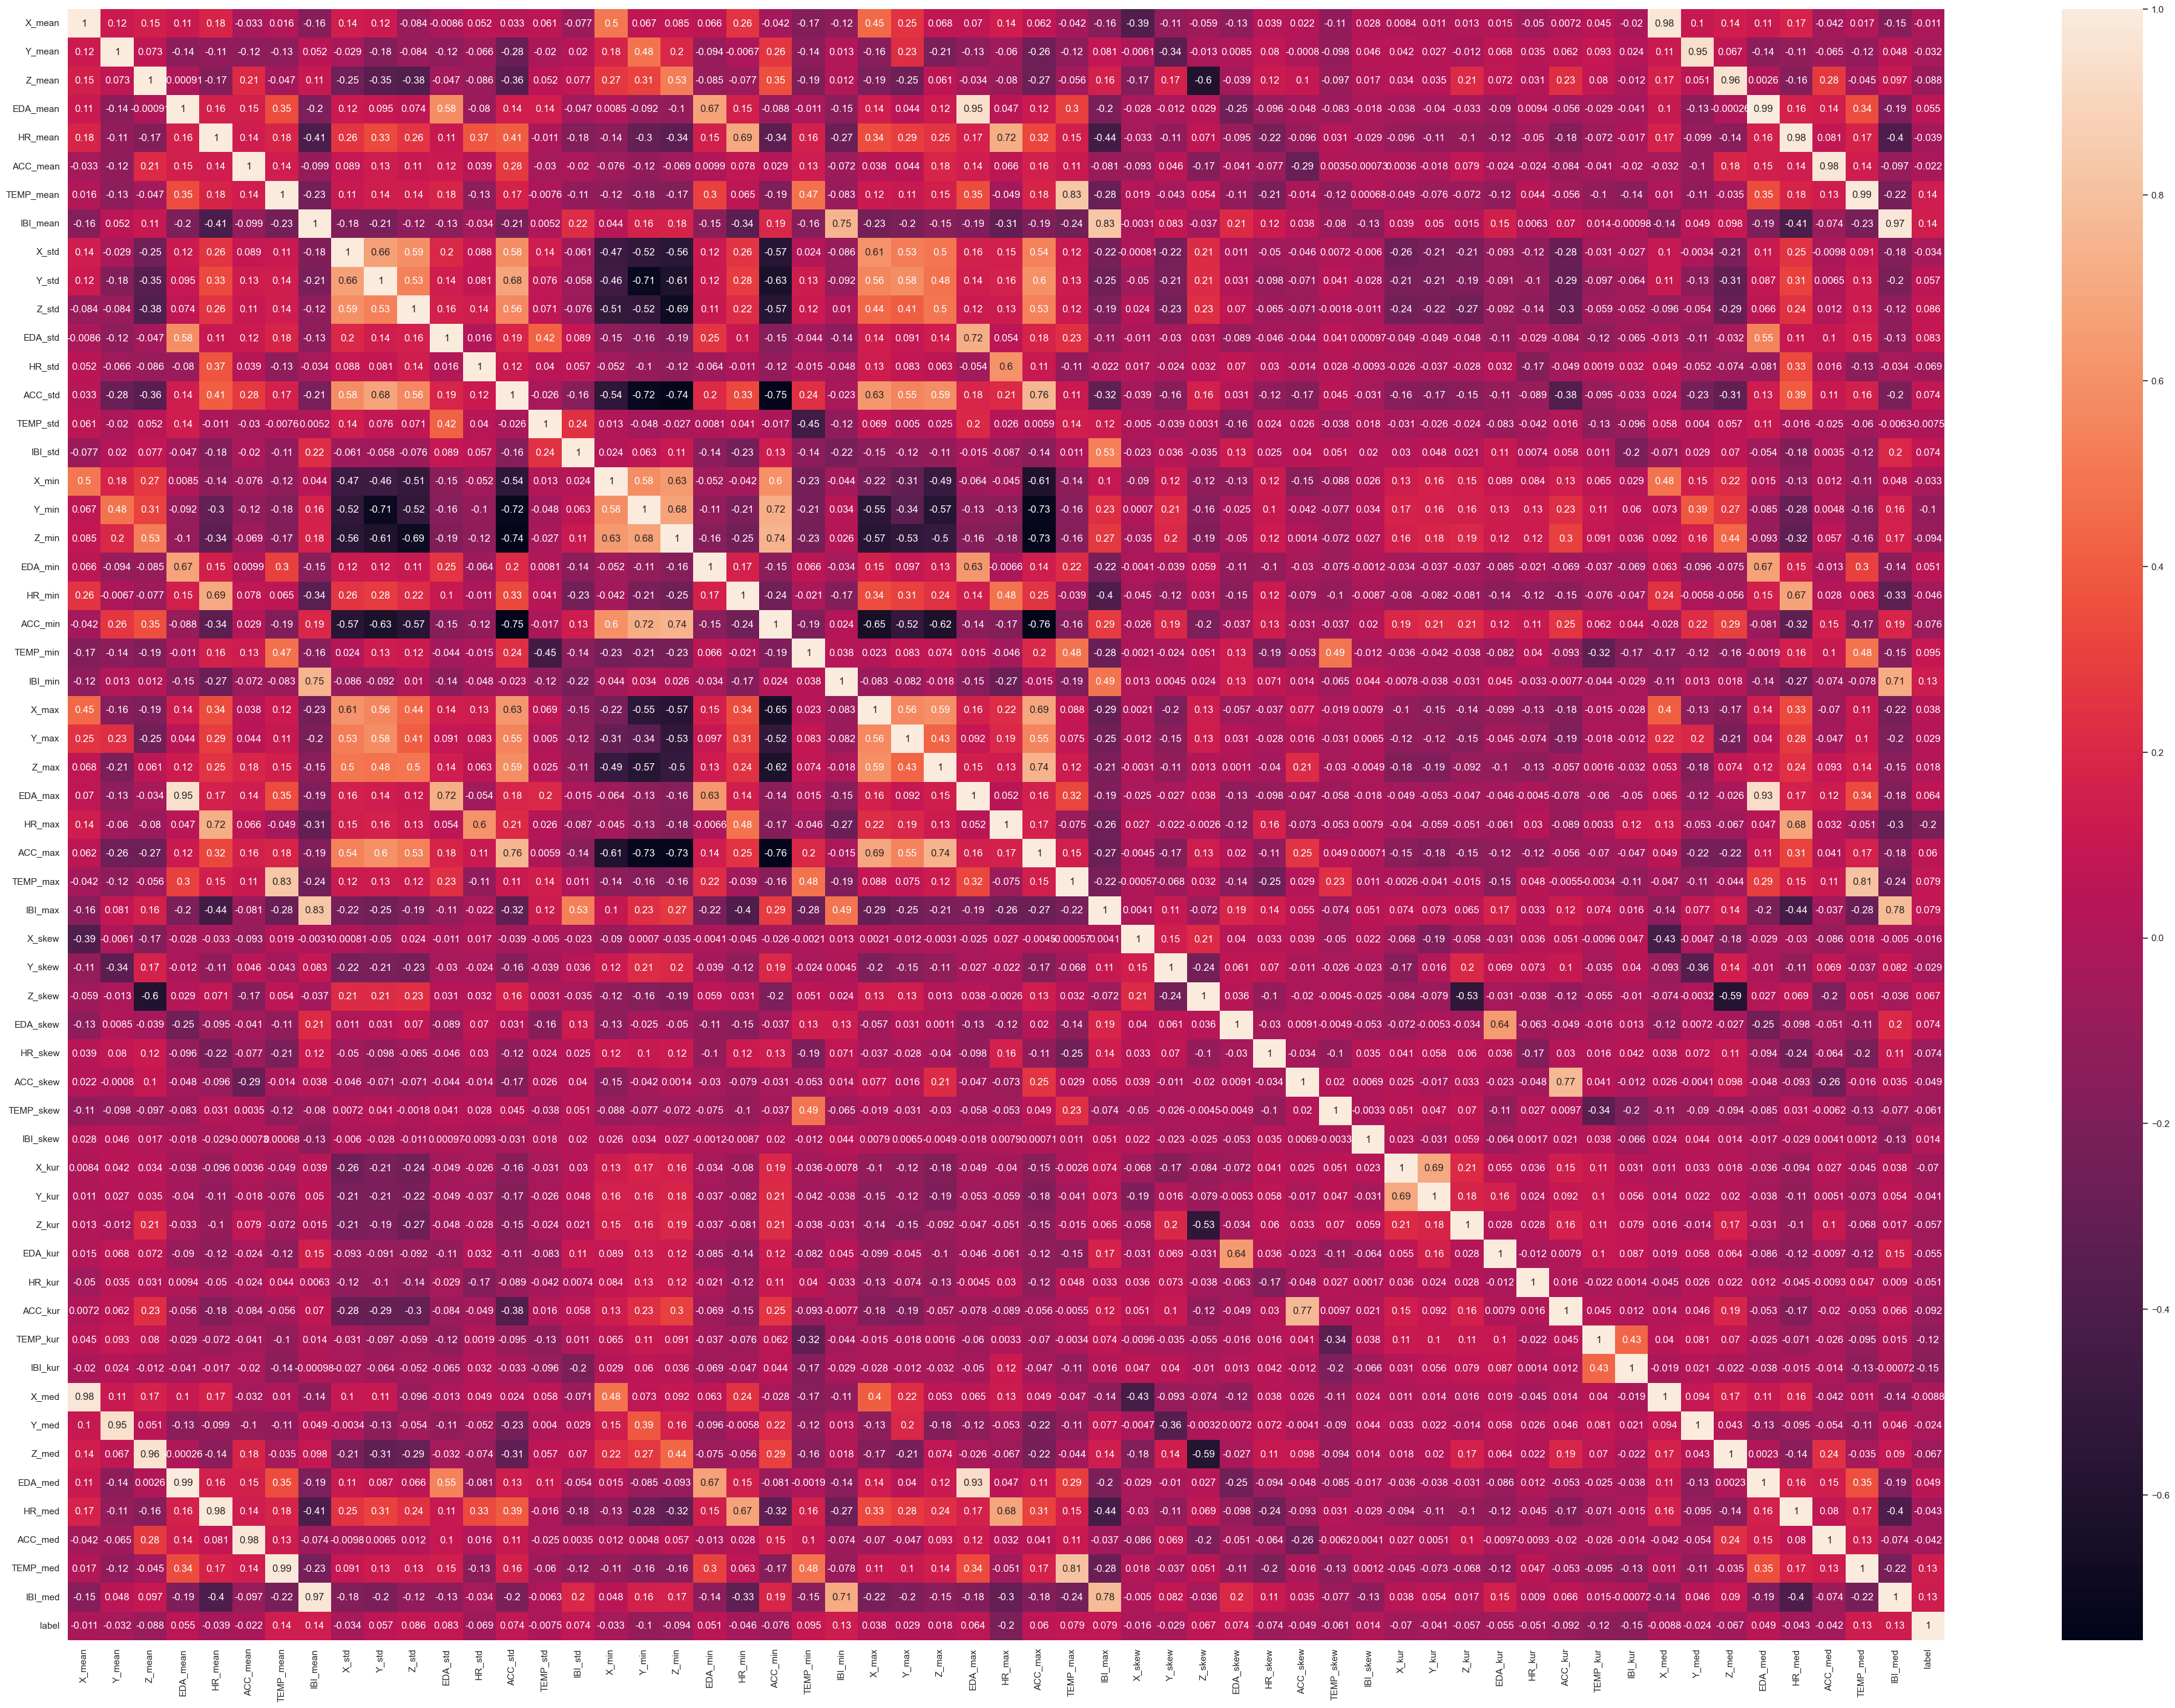

In [7]:
temp = df_featured
fig = plt.figure(figsize=(50,35))
sns.heatmap(temp.corr(),annot=True)

From above it can be seen that, median and mean of every signal have correlation to each other over 0.95 that's mean we can remove mean or median out of feature because they'll effect to model performance too similar to  to make model train faster

** noted after try to remove the feature mentioned above the performance of model is dropped

# Model training and evaluation

Once features have been extracted from the time series data, the order of the data may no longer be as important. This is because the features are designed to capture patterns and trends in the data within a fixed window size, and the goal is typically to predict a target variable independently for each window.

For example, in a real-world scenario, a model might be trained on 30-second windows of data and then used to predict the user's stress level for the next 30 seconds. In this case, the order of the windows may not matter as much, since the model is designed to capture patterns and trends within each window independently.

This means that the windows of data can be shuffled and used for k-fold cross-validation, since the order of the data is less important for predicting the target variable.

## Data partition - Train Test Split

In [8]:
# define X and y
X = df_featured.drop(['label'], axis = 1).values
y = df_featured['label'].values

# use OneHotEncoder to change muticlasses to binary vector
encoder = OneHotEncoder(categories='auto')
y_enc = encoder.fit_transform(y.reshape(-1, 1)).toarray()

In [9]:
print(f"y = {y}")
print(f"y_enc = {y_enc}")

y = [0. 0. 0. ... 2. 2. 2.]
y_enc = [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [10]:
# split train and test into train 80% and test 20% using stratify = y to make class on testset have the same porpotion
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y)
print(f'Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}')

Train size: 4805, Test size: 1202


From above it can be seen that y had changed to binary vector

## Model Training With original dataset Evaluate with crossvalidation 5 Folds (Default hyper parameter)

In [11]:
rf = ('RF',RandomForestClassifier())
svc = ('SVC',SVC())
xgb = ('XGB',XGBClassifier(objective='multi:softmax', num_class = 3))
mlp = ('MLP',MLPClassifier())

rf_Original, rf_scaler, rf_df = fn.Model_train(X_train, y_train, False, rf)
svc_Original, svc_scaler, svc_df = fn.Model_train(X_train, y_train, False, svc)
xgb_Original, xgb_scaler, xgb_df = fn.Model_train(X_train, y_train, False, xgb)
mlp_Original, mlp_scaler, mlp_df = fn.Model_train(X_train, y_train, False, mlp)

df_metric = pd.concat([rf_df,svc_df,xgb_df,mlp_df], axis = 0)
df_metric = df_metric.reset_index(drop=True)
df_metric

,model,accuracy,precision,recall,f1
0,RF,0.863476,0.958139,0.616202,0.703313
1,SVC,0.829136,0.897137,0.536628,0.601638
2,XGB,0.925702,0.941786,0.815638,0.867286
3,MLP,0.813528,0.778147,0.675256,0.716903


### Evaluate with test set

================== Random Forest ==================
              precision    recall  f1-score   support

           0       0.84      0.64      0.72       226
           1       1.00      0.38      0.55        84
           2       0.89      1.00      0.94       892

    accuracy                           0.89      1202
   macro avg       0.91      0.67      0.74      1202
weighted avg       0.89      0.89      0.87      1202



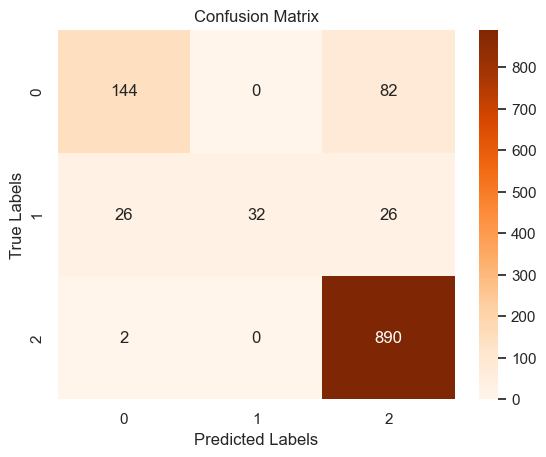

================== Support vector machine ==================
              precision    recall  f1-score   support

           0       0.91      0.40      0.56       226
           1       1.00      0.25      0.40        84
           2       0.82      1.00      0.90       892

    accuracy                           0.83      1202
   macro avg       0.91      0.55      0.62      1202
weighted avg       0.85      0.83      0.80      1202



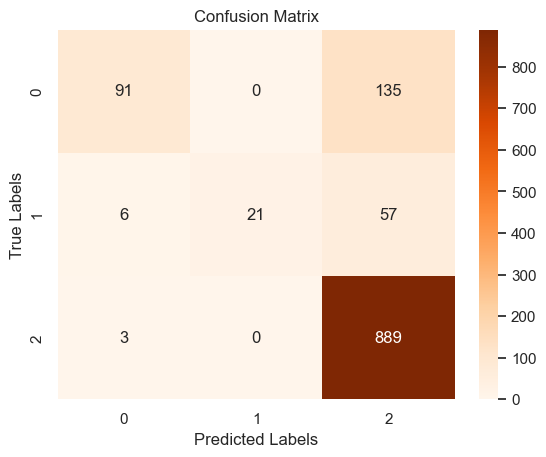

================== XGBClassifier ==================
              precision    recall  f1-score   support

           0       0.98      0.73      0.84       226
           1       0.95      0.74      0.83        84
           2       0.92      1.00      0.96       892

    accuracy                           0.93      1202
   macro avg       0.95      0.82      0.88      1202
weighted avg       0.93      0.93      0.93      1202



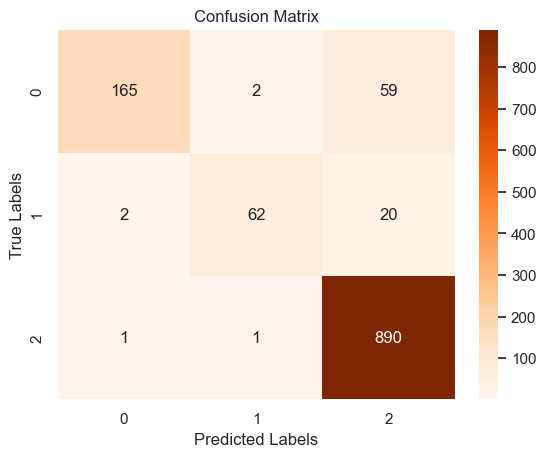

================== MLPClassifier ==================
              precision    recall  f1-score   support

           0       0.63      0.71      0.67       226
           1       0.76      0.54      0.63        84
           2       0.91      0.91      0.91       892

    accuracy                           0.84      1202
   macro avg       0.77      0.72      0.74      1202
weighted avg       0.85      0.84      0.84      1202



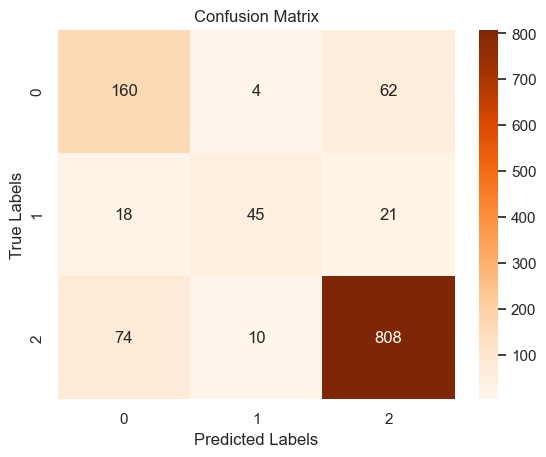

In [12]:
fn.eval_testset("Random Forest", rf_Original, rf_scaler, X_test, y_test)
fn.eval_testset("Support vector machine", svc_Original, svc_scaler, X_test, y_test)
fn.eval_testset("XGBClassifier", xgb_Original, xgb_scaler, X_test, y_test)
fn.eval_testset("MLPClassifier", mlp_Original, mlp_scaler, X_test, y_test)

## Model Training with Upsampling dataset using SMOTE Evaluate with crossvalidation 5 Folds (Default hyperparameter)

In [13]:
rf_SM, rf_scaler_SM, rf_df_SM = fn.Model_train(X_train, y_train, True, rf)
svc_SM, svc_scaler_SM, svc_df_SM = fn.Model_train(X_train, y_train, True, svc)
xgb_SM, xgb_scaler_SM, xgb_df_SM = fn.Model_train(X_train, y_train, True, xgb)
mlp_SM, mlp_scaler_SM, mlp_df_SM = fn.Model_train(X_train, y_train, True, mlp)

df_metric_SM = pd.concat([rf_df_SM,svc_df_SM,xgb_df_SM,mlp_df_SM], axis = 0)
df_metric_SM = df_metric_SM.reset_index(drop=True)
df_metric_SM #Performance of model train on SMOTE dataset

,model,accuracy,precision,recall,f1
0,RF,0.847242,0.940738,0.739467,0.822597
1,SVC,0.799792,0.655112,0.734114,0.685493
2,XGB,0.917170,0.868980,0.833438,0.849152
3,MLP,0.773361,0.733885,0.698071,0.714252


In [14]:
df_metric

,model,accuracy,precision,recall,f1
0,RF,0.863476,0.958139,0.616202,0.703313
1,SVC,0.829136,0.897137,0.536628,0.601638
2,XGB,0.925702,0.941786,0.815638,0.867286
3,MLP,0.813528,0.778147,0.675256,0.716903


From above it can be seen that after SMOTE on training set recall of model is increasing, due to requirement of project description "The company is particularly worried about false negatives, as they are trying to convince the hospital to sign a contract with them and this is conditional on having high recall."

### Tuning hyper parameter

In [15]:
# all model and tuning parameter
model_params = {
    'RF': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [100,400,700,1000],
            'max_features': ["sqrt"],
            'max_depth' : [3,5,None],
            'min_samples_split' : [2, 5, 10],
            'min_samples_leaf' : [1, 2, 4],
            'bootstrap': [True, False],
        }
    },
    'SVC': {
        'model': SVC(),
        'params' : {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'degree': [3, 4, 5],
            'gamma': ['scale', 'auto']
        }
    },
    'XGB': 
        {
        'model': XGBClassifier(objective='multi:softmax', num_class = 3),
        'params' : {
            'max_depth': [ 3, 4, 5, 6, 8, 10, 12, 15 ],
            'learning_rate': [ 0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
            'n_estimators': [ 50, 75, 100, 125, 150 ],
            'min_child_weight': [ 1, 3, 5, 7 ],
            'gamma': [ 0.0, 0.1, 0.2, 0.3, 0.4 ],
            'colsample_bytree': [ 0.3, 0.4, 0.5, 0.7 ],
        }  
    },
    'MLP' : {
        'model': MLPClassifier(),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50,50,), (100,100,)],
            'max_iter': [200,800,1600],
            'early_stopping': [True],
            'activation': ['relu', 'tanh', 'logistic'],
            'solver': ['adam', 'lbfgs', 'sgd'],
            'learning_rate': ['constant', 'invscaling', 'adaptive']
        }
    },
}

In [16]:
# implement tuning parameter function
parameter = []
for name, mp in model_params.items():
    print(mp['model'])    
    best = fn.SearchCV(X_train, y_train, name, mp)
    parameter.append((name, best))

RandomForestClassifier()
Scoring = None
SVC()
Scoring = None
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=3,
              num_parallel_tree=None, objective='multi:softmax', ...)
Scoring = None
MLPClassifier()
Scoring = None


In [17]:
parameter

[('RF',
  [{'best_score': 0.8666866736218118,
    'best_params': {'n_estimators': 400,
     'min_samples_split': 2,
     'min_samples_leaf': 1,
     'max_features': 'sqrt',
     'max_depth': None,
     'bootstrap': True},
    'best_estimator': RandomForestClassifier(n_estimators=400)}]),
 ('SVC',
  [{'best_score': 0.9619778075578275,
    'best_params': {'kernel': 'rbf', 'gamma': 'scale', 'degree': 5, 'C': 100},
    'best_estimator': SVC(C=100, degree=5)}]),
 ('XGB',
  [{'best_score': 0.9765513975040051,
    'best_params': {'n_estimators': 150,
     'min_child_weight': 3,
     'max_depth': 10,
     'learning_rate': 0.25,
     'gamma': 0.1,
     'colsample_bytree': 0.5},
    'best_estimator': XGBClassifier(base_score=None, booster=None, callbacks=None,
                  colsample_bylevel=None, colsample_bynode=None,
                  colsample_bytree=0.5, early_stopping_rounds=None,
                  enable_categorical=False, eval_metric=None, feature_types=None,
                  gamma=

## Train model and eval using 5-folds cross validation with tuned parameters using SMOTE training set

In [18]:
rf = ('RF',RandomForestClassifier(**parameter[0][1][0]['best_params']))
svc = ('SVC',SVC(**parameter[1][1][0]['best_params']))
xgb = ('XGB',XGBClassifier(**parameter[2][1][0]['best_params']))
mlp = ('MLP',MLPClassifier(**parameter[3][1][0]['best_params']))

rf_SM_tuned, rf_scaler_tuned, rf_df_tuned = fn.Model_train(X_train, y_train, True, rf)
svc_SM_tuned, svc_scaler_tuned, svc_df_tuned = fn.Model_train(X_train, y_train, True, svc)
xgb_SM_tuned, xgb_scaler_tuned, xgb_df_tuned = fn.Model_train(X_train, y_train, True, xgb)
mlp_SM_tuned, mlp_scaler_tuned, mlp_df_tuned = fn.Model_train(X_train, y_train, True, mlp)

df_metric_SM_tuned = pd.concat([rf_df_tuned,svc_df_tuned,xgb_df_tuned,mlp_df_tuned], axis = 0)
df_metric_SM_tuned = df_metric_SM_tuned.reset_index(drop=True)
df_metric_SM_tuned

,model,accuracy,precision,recall,f1
0,RF,0.848283,0.940948,0.744165,0.826501
1,SVC,0.846202,0.747066,0.709734,0.726184
2,XGB,0.925702,0.891990,0.847803,0.867392
3,MLP,0.809781,0.736115,0.709071,0.720631


Above is model performance on SMOTE dataset

In [19]:
df_metric

,model,accuracy,precision,recall,f1
0,RF,0.863476,0.958139,0.616202,0.703313
1,SVC,0.829136,0.897137,0.536628,0.601638
2,XGB,0.925702,0.941786,0.815638,0.867286
3,MLP,0.813528,0.778147,0.675256,0.716903


Above is model performance on Original Dataset

### Evaluate with test set

================== Random Forest ==================
              precision    recall  f1-score   support

           0       0.69      0.87      0.77       226
           1       0.87      0.62      0.72        84
           2       0.96      0.92      0.94       892

    accuracy                           0.89      1202
   macro avg       0.84      0.80      0.81      1202
weighted avg       0.90      0.89      0.89      1202



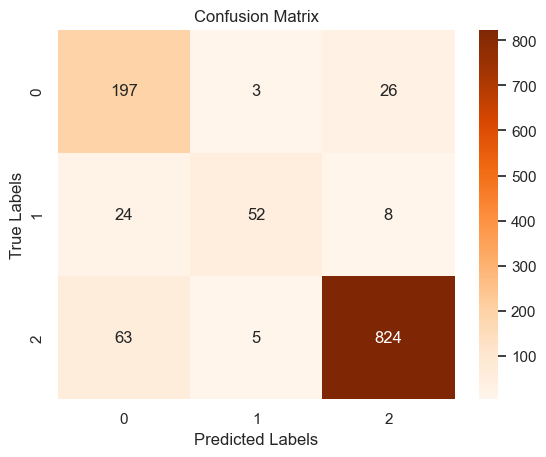

================== Support vector machine ==================
              precision    recall  f1-score   support

           0       0.72      0.65      0.69       226
           1       0.67      0.56      0.61        84
           2       0.89      0.92      0.91       892

    accuracy                           0.85      1202
   macro avg       0.76      0.71      0.73      1202
weighted avg       0.84      0.85      0.84      1202



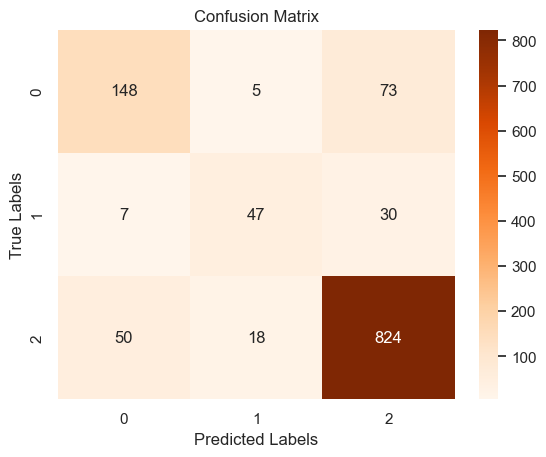

================== XGBClassifier ==================
              precision    recall  f1-score   support

           0       0.91      0.77      0.83       226
           1       0.78      0.74      0.76        84
           2       0.93      0.97      0.95       892

    accuracy                           0.92      1202
   macro avg       0.87      0.82      0.85      1202
weighted avg       0.91      0.92      0.91      1202



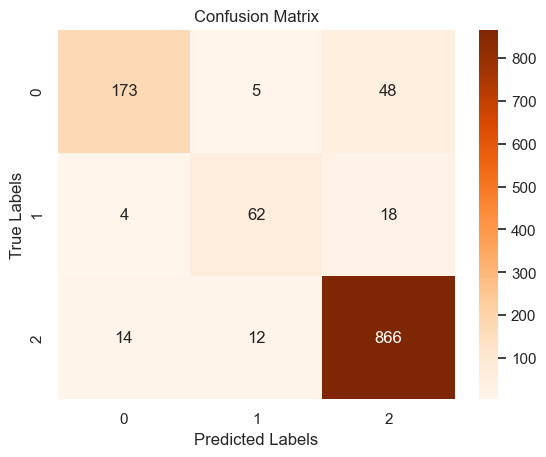

================== MLPClassifier ==================
              precision    recall  f1-score   support

           0       0.63      0.70      0.67       226
           1       0.66      0.58      0.62        84
           2       0.90      0.89      0.90       892

    accuracy                           0.83      1202
   macro avg       0.73      0.72      0.73      1202
weighted avg       0.84      0.83      0.83      1202



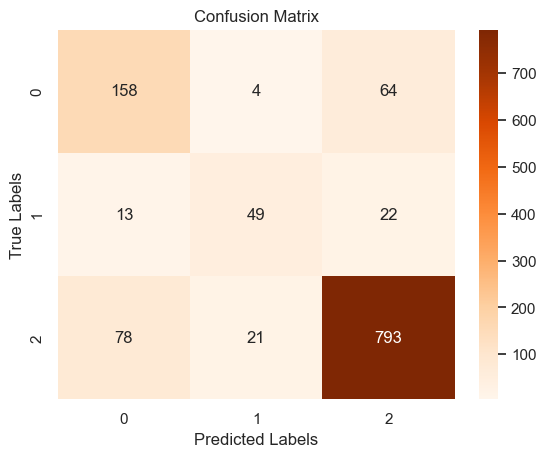

In [25]:
fn.eval_testset("Random Forest", rf_SM_tuned, rf_scaler_tuned, X_test, y_test)
fn.eval_testset("Support vector machine", svc_SM_tuned, svc_scaler_tuned, X_test, y_test)
fn.eval_testset("XGBClassifier", xgb_SM_tuned, xgb_scaler_tuned, X_test, y_test)
fn.eval_testset("MLPClassifier", mlp_SM_tuned, mlp_scaler_tuned, X_test, y_test)

### Compare model performance between original dataset vs SMOTE dataset

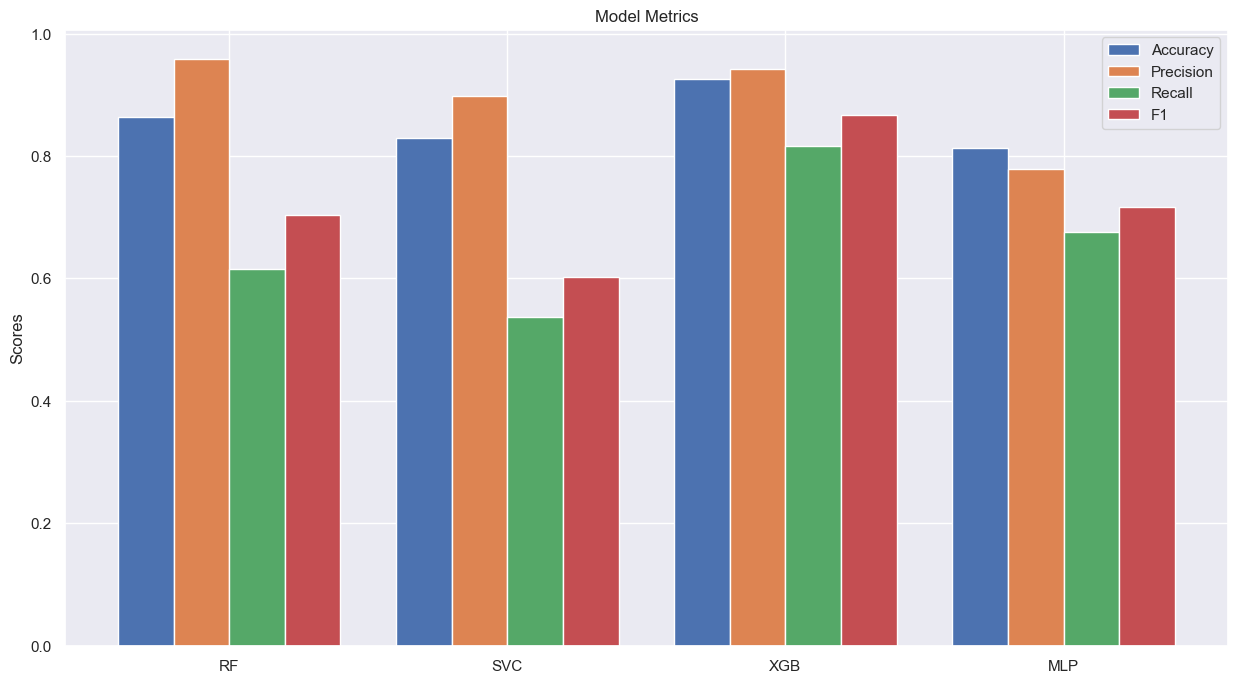

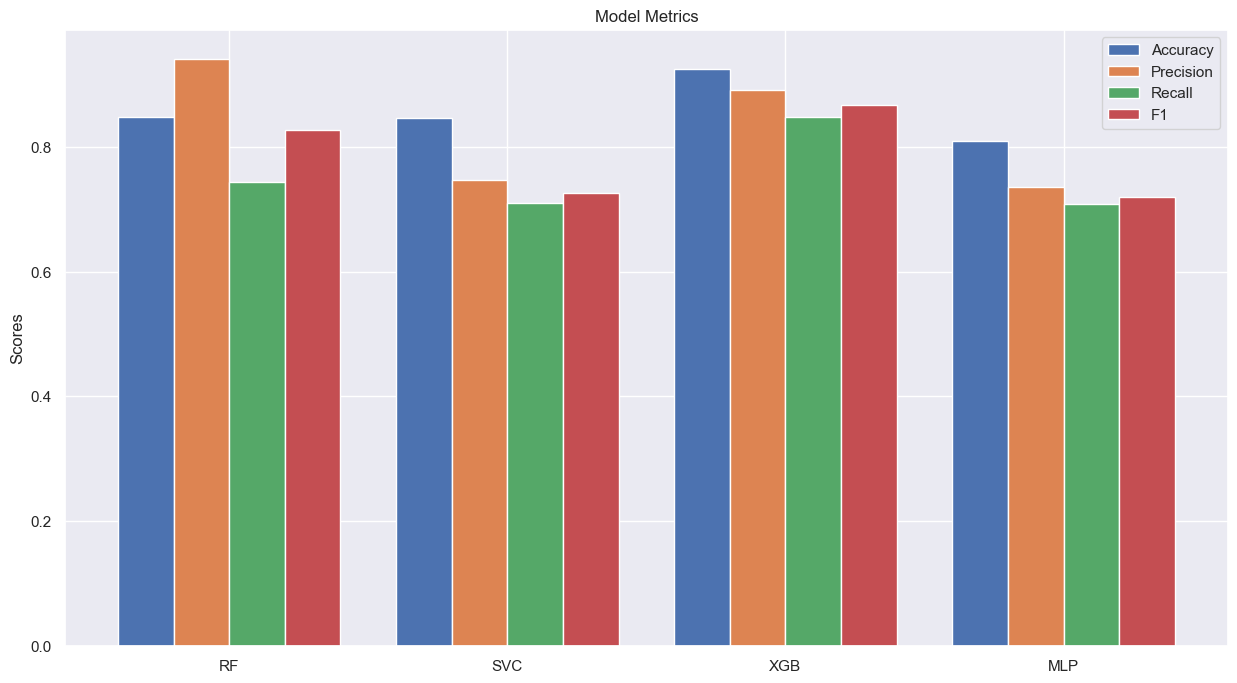

In [21]:
fn.model_performance_bar(df_metric)
fn.model_performance_bar(df_metric_SM_tuned)

# Feature importance

Find importance of Feature from best model

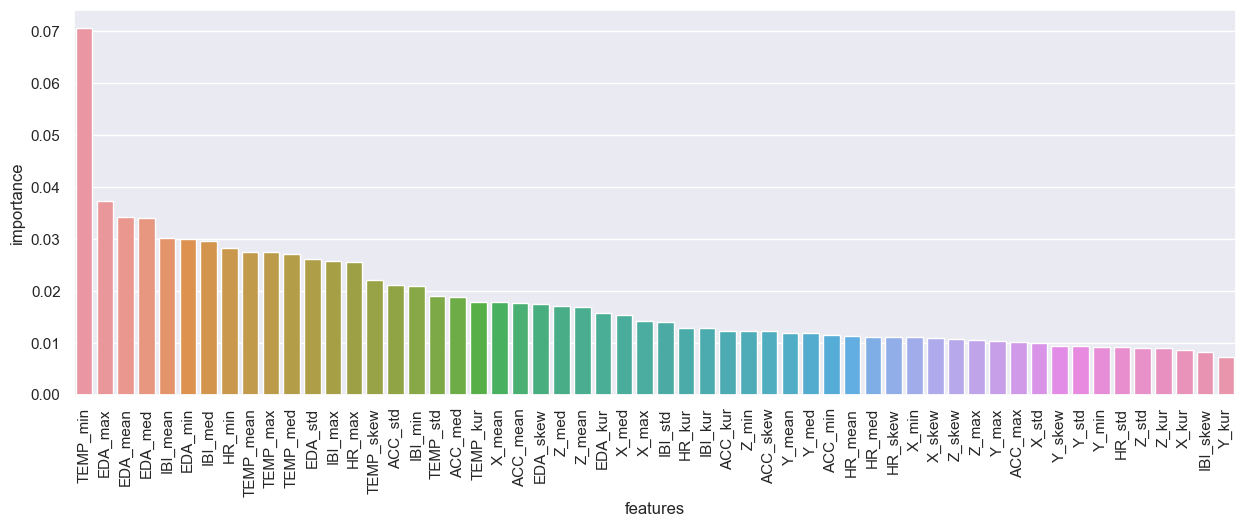

In [24]:
# plot the graph importance
importances = pd.Series(rf_SM_tuned.feature_importances_, index= df_featured.drop(['label'], axis = 1).columns.tolist())
importances = importances.sort_values(ascending=False)
importances = pd.DataFrame({
    "features": importances.index,
    "importance": importances.values
})

fig = plt.figure(figsize=(15,5))

sns.barplot(data=importances, x='features', y='importance')

_ = plt.xticks(rotation=90)

From above, it can be seen that TEMP, EDA, and IBI value are on first half of feature impoertance 